[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cahemobu97/AI4ENG/blob/main/04_ModeloXGBoost.ipynb)

In [34]:
#En este primer paso vamos a importar las librerias necesarias para hacer la exploración de datos
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json
%matplotlib inline
#Importacion de Bibliotecas de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')

import seaborn as sns # Para la visualización de mejor calidad


In [35]:
# Cargando credenciales de Kaggel
data = {"username": "carloshernanm", "key": "c4e8b9a467c0efe0b0d0495e83185ba1"}
with open('kaggle.json', 'w') as file:
    json.dump(data, file, indent=4)

!cp kaggle.json ~/.kaggle/

In [36]:
# Se descarga el dataset
!kaggle datasets download -d emmanuelfwerr/thyroid-disease-data

# Se descomprime el dataset
!unzip thyroid-disease-data.zip

thyroid-disease-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  thyroid-disease-data.zip
replace thyroidDF.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: thyroidDF.csv           


In [37]:
#Verificamos que se este funcionando la conexión de la API
!kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          11300        352  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           9001        285  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01            836         23  1.0              
whenamancodes/credit-card-customers-prediction                  Credit Card Cust

In [38]:
#Vamos a leer los datos que tiene el dataset para empezar con el análisis explorartorio
thyroidDF = pd.read_csv("thyroidDF.csv")
thyroidDF.head(10)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
5,60,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803048
6,77,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,21.0,other,-,840803068
7,28,F,f,f,f,f,f,f,f,f,...,116.0,f,NaN,f,NaN,f,NaN,SVI,-,840807019
8,28,F,f,f,f,f,f,f,f,f,...,76.0,f,NaN,f,NaN,f,NaN,other,-,840808060
9,28,F,f,f,f,f,f,f,f,f,...,83.0,f,NaN,f,NaN,f,NaN,other,-,840808073


In [39]:
# Procemos a eliminar los datos redudantes del dataset
thyroidDF.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id', 'referral_source'], axis=1, inplace=True)


In [40]:
#Reasignamos valores objetivo al grupo de diagnostico
diagnosticos = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

In [41]:
thyroidDF['target'] = thyroidDF['target'].map(diagnosticos) # Hacemos un remapeo para asignar el grupo target al dataframe
# Descartamos observaciones con 'target' nulo después de volver a mapear
thyroidDF.dropna(subset=['target'], inplace=True) 
thyroidDF

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
0,29,F,f,f,f,f,f,f,f,t,...,f,f,f,0.3,NaN,NaN,NaN,NaN,NaN,negative
1,29,F,f,f,f,f,f,f,f,f,...,f,f,f,1.6,1.9,128.0,NaN,NaN,NaN,negative
2,41,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,NaN,NaN,NaN,11.0,negative
3,36,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,NaN,NaN,NaN,26.0,negative
5,60,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,NaN,NaN,NaN,26.0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,70,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,88.0,0.74,119.0,NaN,negative
9167,56,M,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,64.0,0.83,77.0,NaN,negative
9168,22,M,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,91.0,0.92,99.0,NaN,negative
9170,47,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,75.0,0.85,88.0,NaN,negative


In [42]:
thyroidDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7546 non-null   int64  
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   o

In [43]:
# Mostramos la distribución numerica de las variables
thyroidDF.describe()


,age,TSH,T3,TT4,T4U,FTI,TBG
count,7546.000000,6824.000000,5337.000000,7192.000000,6870.000000,6877.000000,259.000000
mean,78.013782,5.421753,2.020935,105.203373,0.967322,110.571745,22.955019
std,1305.258137,26.080471,0.809865,32.606462,0.162315,36.600867,6.088392
min,1.000000,0.005000,0.050000,2.000000,0.190000,1.400000,0.100000
25%,37.000000,0.570000,1.600000,87.000000,0.870000,93.000000,20.000000
50%,55.000000,1.400000,2.000000,103.000000,0.960000,108.000000,23.000000
75%,67.000000,2.700000,2.300000,121.000000,1.060000,125.000000,27.000000
max,65526.000000,530.000000,18.000000,430.000000,2.120000,839.000000,45.000000


In [44]:
#Mostramos las edad mayores a 100 en el dataframe
thyroidDF[thyroidDF.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
2976,455,F,f,f,f,f,f,f,f,f,...,f,f,f,1.10,2.0,118.0,1.13,104.0,NaN,negative
5710,65511,M,f,f,f,f,f,f,f,f,...,f,f,f,0.38,2.0,113.0,1.08,104.0,NaN,negative
6392,65512,M,f,f,f,f,f,f,f,f,...,f,f,f,0.03,2.8,112.0,0.84,133.0,NaN,negative
8105,65526,F,f,f,f,f,f,f,f,f,...,f,f,f,1.50,NaN,132.0,1.02,129.0,NaN,negative


In [45]:
# Reemplazamos los valores de edad mayores a 100 por null
thyroidDF['age'] = np.where((thyroidDF.age > 100), np.nan, thyroidDF.age)

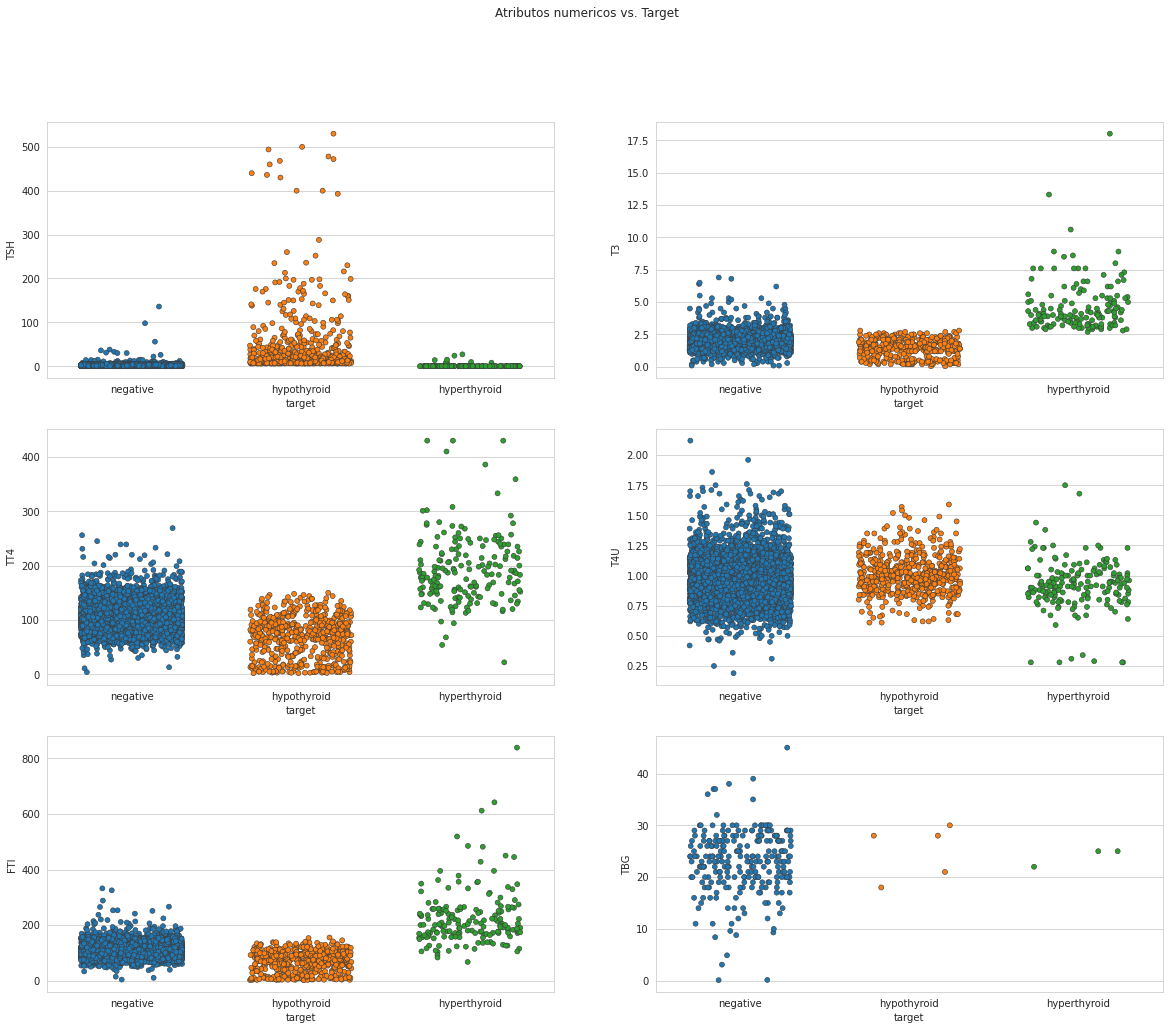

In [46]:
#Configuramos el grid para las multiples graficas de seaborn
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Atributos numericos vs. Target')
sns.set_style('whitegrid');

# TSH vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])

Continuemos creando un gráfico de pares de nuestras variables numéricas y viendo si podemos detectar algún grupo que se forme entre las variables.

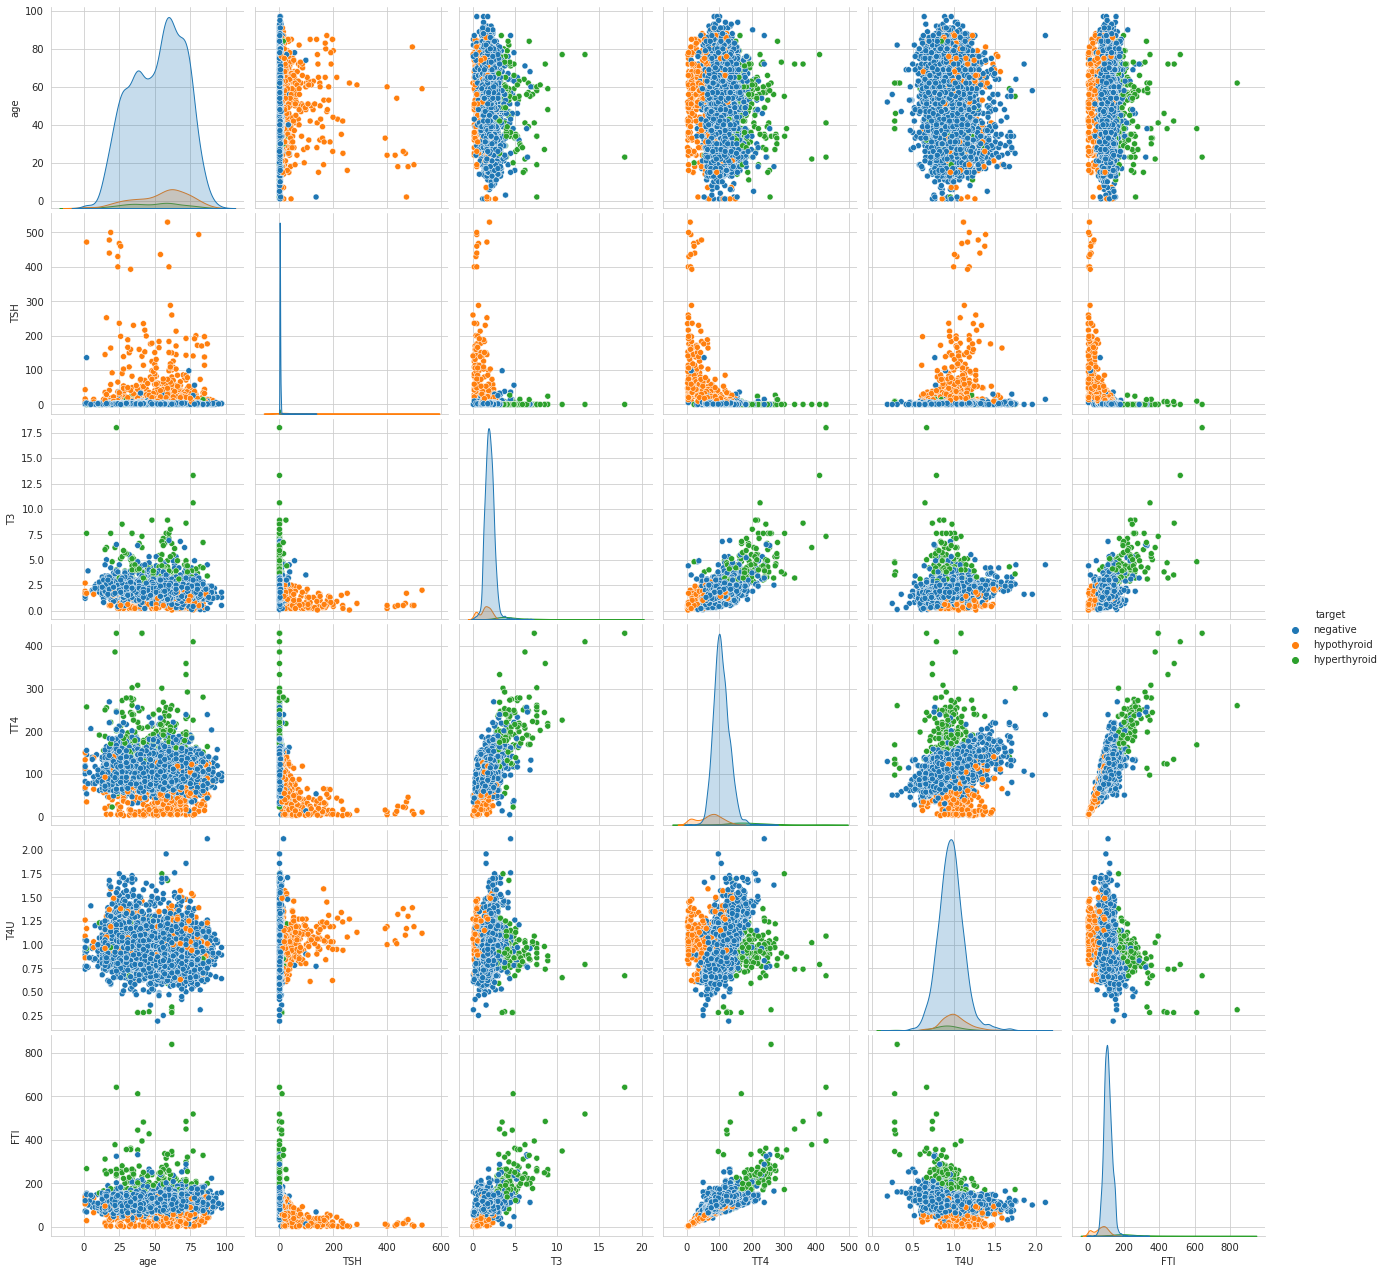

In [47]:
numericalDF = thyroidDF[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()#Copiamos los atributos numericos de interes
sns.set_style('whitegrid');
sns.pairplot(numericalDF, hue='target', height=3);#Hacemos el grafico de pares para las columnas numericas
plt.show()

En las diagonales del gráfico de pares podemos ver las distribuciones de cada variable numérica con respecto a la otra. Es evidente lo desequilibrado que está el conjunto de datos, al tener tantos "targets" negativos en comparación con hipotiroidismo o hipertiroidismo.

Vamos a proceder con la investigación de valores atípicos, 
el siguiente código calcula los rangos entre cuartiles para nuestros atributos numéricos de prueba de hormonas para determinar valores atípicos leves y severos.

In [48]:
# TSH
Q1_TSH = thyroidDF['TSH'].quantile(0.25)
Q3_TSH = thyroidDF['TSH'].quantile(0.75)
IQR_TSH = Q3_TSH - Q1_TSH
under_TSH = thyroidDF['TSH'] < (Q1_TSH - 3 * IQR_TSH)
upper_TSH = thyroidDF['TSH'] > (Q3_TSH + 3 * IQR_TSH)
print('TSH:', 'Valores atipicos leves -', sum(under_TSH), ' | Valores atipicos severos -', sum(upper_TSH))

# T3
Q1_T3 = thyroidDF['T3'].quantile(0.25)
Q3_T3 = thyroidDF['T3'].quantile(0.75)
IQR_T3 = Q3_T3 - Q1_T3
under_T3 = thyroidDF['T3'] < (Q1_T3 - 3 * IQR_T3)
upper_T3 = thyroidDF['T3'] > (Q3_T3 + 3 * IQR_T3)
print('T3:', 'Valores atipicos leves -', sum(under_T3), ' | Valores atipicos severos -', sum(upper_T3))

# TT4
Q1_TT4 = thyroidDF['TT4'].quantile(0.25)
Q3_TT4 = thyroidDF['TT4'].quantile(0.75)
IQR_TT4 = Q3_TT4 - Q1_TT4
under_TT4 = thyroidDF['TT4'] < (Q1_TT4 - 3 * IQR_TT4)
upper_TT4 = thyroidDF['TT4'] > (Q3_TT4 + 3 * IQR_TT4)
print('TT4:', 'Valores atipicos leves -', sum(under_TT4), ' | Valores atipicos severos -', sum(upper_TT4))

# T4U
Q1_T4U = thyroidDF['T4U'].quantile(0.25)
Q3_T4U = thyroidDF['T4U'].quantile(0.75)
IQR_T4U = Q3_T4U - Q1_T4U
under_T4U = thyroidDF['T4U'] < (Q1_T4U - 3 * IQR_T4U)
upper_T4U = thyroidDF['T4U'] > (Q3_T4U + 3 * IQR_T4U)
print('T4U:', 'Valores atipicos leves -', sum(under_T4U), ' | Valores atipicos severos -', sum(upper_T4U))

# FTI
Q1_FTI = thyroidDF['FTI'].quantile(0.25)
Q3_FTI = thyroidDF['FTI'].quantile(0.75)
IQR_FTI = Q3_FTI - Q1_FTI
under_FTI = thyroidDF['FTI'] < (Q1_FTI - 3 * IQR_FTI)
upper_FTI = thyroidDF['FTI'] > (Q3_FTI + 3 * IQR_FTI)
print('FTI:', 'Valores atipicos leves -', sum(under_FTI), ' | Valores atipicos severos -', sum(upper_FTI))

TSH: Valores atipicos leves - 0  | Valores atipicos severos - 456
T3: Valores atipicos leves - 0  | Valores atipicos severos - 84
TT4: Valores atipicos leves - 0  | Valores atipicos severos - 55
T4U: Valores atipicos leves - 7  | Valores atipicos severos - 22
FTI: Valores atipicos leves - 0  | Valores atipicos severos - 83


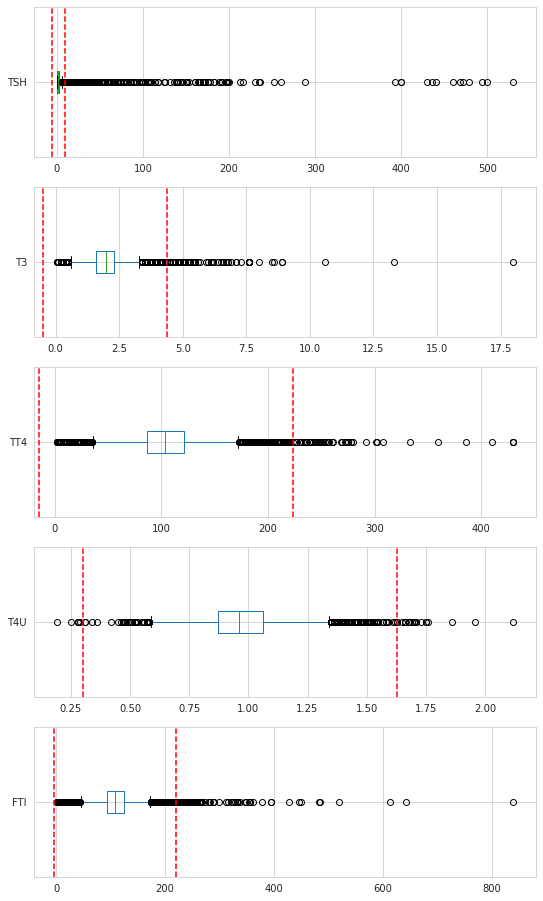

In [49]:
#Vamos a crear los boxplots para visualizar nuestros valores atipicos leves y severos
fig, axs= plt.subplots(nrows = 5, figsize=(9,16))

# TSH
thyroidDF.boxplot(column='TSH', ax=axs[0], vert = False)
axs[0].axvline(x=(Q1_TSH - 3*IQR_TSH), color='r', linestyle='--')
axs[0].axvline(x=(Q3_TSH + 3*IQR_TSH), color='r', linestyle='--')
# T3
thyroidDF.boxplot(column='T3', ax=axs[1], vert = False)
axs[1].axvline(x=(Q1_T3 - 3*IQR_T3), color='r', linestyle='--')
axs[1].axvline(x=(Q3_T3 + 3*IQR_T3), color='r', linestyle='--')
# TT4
thyroidDF.boxplot(column='TT4', ax=axs[2], vert = False)
axs[2].axvline(x=(Q1_TT4 - 3*IQR_TT4), color='r', linestyle='--')
axs[2].axvline(x=(Q3_TT4 + 3*IQR_TT4), color='r', linestyle='--')
# T4U
thyroidDF.boxplot(column='T4U', ax=axs[3], vert = False)
axs[3].axvline(x=(Q1_T4U - 3*IQR_T4U), color='r', linestyle='--')
axs[3].axvline(x=(Q3_T4U + 3*IQR_T4U), color='r', linestyle='--')
# FTI
thyroidDF.boxplot(column='FTI', ax=axs[4], vert = False)
axs[4].axvline(x=(Q1_FTI - 3*IQR_FTI), color='r', linestyle='--')
axs[4].axvline(x=(Q3_FTI + 3*IQR_FTI), color='r', linestyle='--')

Al graficar los boxplots podemos ver que tenemos muchos valores atípicos severos presentes. Sin embargo, este tipo de variación es normal dentro de este contexto debido a que se trata de personas que tendrán alteraciones en estos valores dadas sus condiciones médicas.

In [50]:
# Calculando los datos faltantes de todo el dataframe
missing_data = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('Resumen total de los datos faltantes del dataframe: {:.2f}%'.format(missing_data * 100))

#Funcion para visualizar el total y el porcentaje de los datos faltantes del dataframe
def missing_table_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
    return missing_data

#Analizamos los datos faltantes
missing_table_data(thyroidDF).head(10)

Resumen total de los datos faltantes del dataframe: 7.54%


,Total,Porcentaje
TBG,7287,0.965677
T3,2209,0.292738
TSH,722,0.095680
T4U,676,0.089584
FTI,669,0.088656
TT4,354,0.046912
sex,250,0.033130
age,4,0.000530
goitre,0,0.000000
psych,0,0.000000


In [51]:
#Eliminamos el atributo TBG del dataframe ya que tiene muchos datos y no aporta nada en nuestro estudio
thyroidDF.drop(['TBG'], axis=1, inplace=True)

#Eliminamos las 4 edades que estaban mal del dataframe
thyroidDF.dropna(subset=['age'], inplace=True)

# Cambiamos las observaciones a ('pregnant' == True) & ('sex' == null) en las mujeres
thyroidDF['sex'] = np.where((thyroidDF.sex.isnull()) & (thyroidDF.pregnant == 't'), 'F', thyroidDF.sex)
thyroidDF

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,target
0,29.0,F,f,f,f,f,f,f,f,t,...,f,f,f,f,0.3,NaN,NaN,NaN,NaN,negative
1,29.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,1.6,1.9,128.0,NaN,NaN,negative
2,41.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,NaN,NaN,NaN,negative
3,36.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,NaN,NaN,NaN,negative
5,60.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,NaN,NaN,NaN,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,70.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,88.0,0.74,119.0,negative
9167,56.0,M,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,64.0,0.83,77.0,negative
9168,22.0,M,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,91.0,0.92,99.0,negative
9170,47.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,NaN,NaN,75.0,0.85,88.0,negative


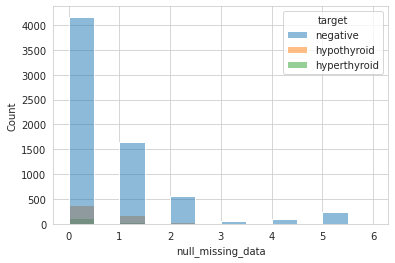

In [52]:
#Contamos los valores faltantes por fila
thyroidDF['null_missing_data'] = thyroidDF.isnull().sum(axis=1)
sns.histplot(thyroidDF, x='null_missing_data', binwidth=0.5, hue='target');

In [53]:
# Calculando los datos faltantes de todo el dataframe nuevamente
missing_data = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('Resumen total de los datos faltantes del dataframe: {:.2f}%'.format(missing_data * 100))

# Vamos a remover las columnas con 3 o mas datos faltantes
thyroidDF.drop(thyroidDF.index[thyroidDF['null_missing_data'] > 2], inplace=True)

missing_table_data(thyroidDF).head(10)

Resumen total de los datos faltantes del dataframe: 2.89%


,Total,Porcentaje
T3,1910,0.267432
TSH,406,0.056847
T4U,290,0.040605
FTI,283,0.039625
sex,208,0.029123
TT4,6,0.000840
age,0,0.000000
goitre,0,0.000000
target,0,0.000000
psych,0,0.000000


Como se puede observar al eliminar la columna TBG y tomar solo las columnas que tengan dos o menos datos faltantes obtenemos un total de solo 2.89% de datos faltantes en el dataframe 

Ahora vamos a proceder a usar XGBoost(Extreme Gradient Boosting) que es uno de los algoritmos de machine learning de tipo supervisado más usados en la actualidad e ideal para manejar el desequilibrio severo entre clases. Gracias a su parámetro sample_weight que ayudar a contrarrestar este desequilibrio.

In [54]:
#Importamos la librerias que vamos a usar con XGBoost
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

# Reemplazamos los valores boleanos de strings con valores binarios de 0 y 1
thyroidDF.replace('f', 0, inplace=True)
thyroidDF.replace('t', 1, inplace=True)

# Reemplazamos el sexo con el binario de 0 y 1
thyroidDF.replace('M', 0, inplace=True) # Hombres es 0
thyroidDF.replace('F', 1, inplace=True) # Mujeres es 1

xgbDF = thyroidDF.replace(np.nan, 0) # Reemplazzamos los valores nan con 0

# Re mapeamos los valores target del grupo de diagnostico

diagnostic_groups = {'negative': 0,
             'hypothyroid': 1, 
             'hyperthyroid': 2}

xgbDF['target'] = xgbDF['target'].map(diagnostic_groups) #Hacemos el re-mapeo

#Creacion de las variables train y test de manera estratificada
X = xgbDF.drop('target', axis=1).copy()
y = xgbDF['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

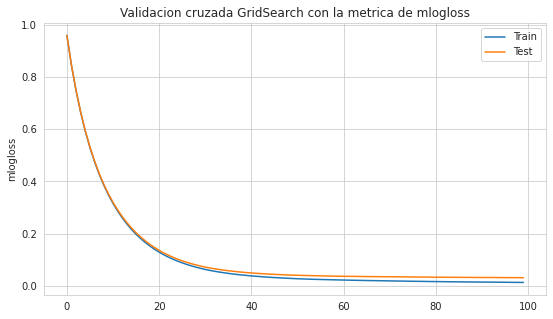

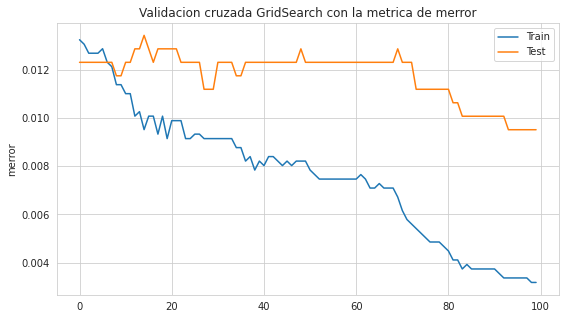


----------------Matriz de confusion --------------------

[[1588    5    4]
 [   0  145    0]
 [   8    0   36]]

---------------Reporte del modelo ----------------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      1.00      0.98       145
           2       0.90      0.82      0.86        44

    accuracy                           0.99      1786
   macro avg       0.95      0.94      0.94      1786
weighted avg       0.99      0.99      0.99      1786



In [55]:
## ---------- XGBoost Modelo 1 ----------
## Ejecución base del modelo con hiperparámetros predeterminados

xgb_v1 = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
xgb_v1.fit(X_train, 
            y_train,
            verbose=0, 
            eval_set=[(X_train, y_train), (X_test, y_test)])

#Preparamos las graficas para revisar las evaluaciones metricas realizadas
resultados = xgb_v1.evals_result()
epochs = len(resultados['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Ploteamos el 'mlogloss' obtenido con el XGBoost
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, resultados['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, resultados['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Validacion cruzada GridSearch con la metrica de mlogloss')
plt.show()

# Ploteamos el 'merror' obtenido con el XGBoost
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, resultados['validation_0']['merror'], label='Train')
ax.plot(x_axis, resultados['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Validacion cruzada GridSearch con la metrica de merror')
plt.show()

## ---------- Reporte del modelo de clasificación ----------

y_pred = xgb_v1.predict(X_test)

print('\n----------------Matriz de confusion --------------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n---------------Reporte del modelo ----------------------\n')
print(classification_report(y_test, y_pred))


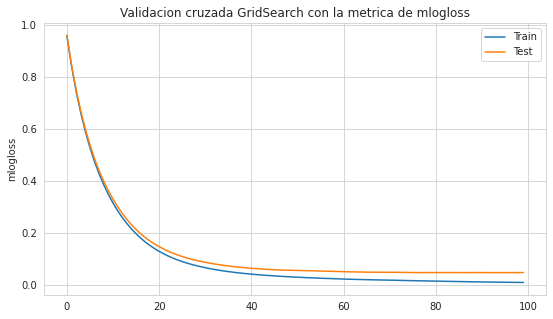

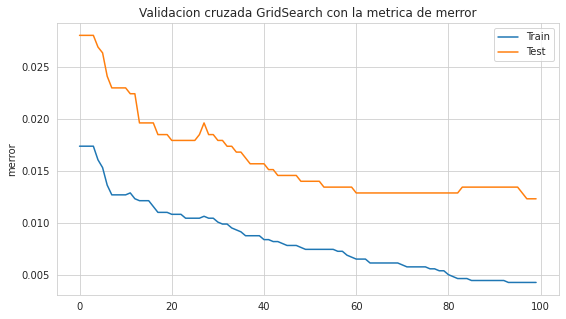


----------------Matriz de confusion --------------------

[[1578    7   12]
 [   0  145    0]
 [   3    0   41]]

---------------Reporte del modelo ----------------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.95      1.00      0.98       145
           2       0.77      0.93      0.85        44

    accuracy                           0.99      1786
   macro avg       0.91      0.97      0.94      1786
weighted avg       0.99      0.99      0.99      1786



In [56]:
## ---------- XGBoost Modelo V2 ----------
## Version 2 del modelo ejecutando con hiperparámetros "optimizados" y
## tratando de mejorar las clases objetivo desequilibradas

#Balanceamos los pesos de clase 'target'
sample_weights = compute_sample_weight(
    class_weight='balanced', 
    y=y_train)

#Declaramos y ajustamos el clasificador con los mejores parametros
xgb_v2 = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, #Valor por defecto de gamma
                            learning_rate=0.1,
                            max_depth=5, 
                            reg_lambda=1, # Valor por defecto de lambda
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_v2.fit(X_train, 
            y_train,
            verbose=0, 
            sample_weight=sample_weights, #pesos de clase para combatir el 'target' desequilibrado
            eval_set=[(X_train, y_train), (X_test, y_test)])

#Preramos las graficas para revisar las evaluaciones metricas realizadas
resultados = xgb_v2.evals_result()
epochs = len(resultados['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Ploteamos el 'mlogloss' obtenido con el XGBoost
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, resultados['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, resultados['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Validacion cruzada GridSearch con la metrica de mlogloss')
plt.show()

# Ploteamos el 'merror' obtenido con el XGBoost
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, resultados['validation_0']['merror'], label='Train')
ax.plot(x_axis, resultados['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Validacion cruzada GridSearch con la metrica de merror')
plt.show()

## ---------- Reporte del modelo de clasificación ----------

y_pred = xgb_v2.predict(X_test)

print('\n----------------Matriz de confusion --------------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n---------------Reporte del modelo ----------------------\n')
print(classification_report(y_test, y_pred))

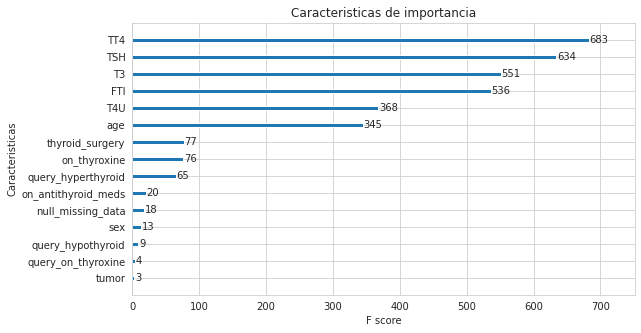

In [57]:
## ---------- Grafica de caracteristicas de importancia ----------
## Graficamos las caracteristicas de importancia del mejor modelo, en este caso, seria el modelo numero 2

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_v2, ax=ax)
plt.title("Caracteristicas de importancia")
plt.ylabel("Caracteristicas")
plt.show()